# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import logging
import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from dotenv import load_dotenv

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

In [3]:
load_dotenv()

True

In [4]:
from botocore.client import Config
from botocore.exceptions import ClientError

AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
S3_BUCKET_NAME = os.getenv("S3_BUCKET_NAME")
endpoint_url = 'https://storage.yandexcloud.net' 
s3 = boto3.client('s3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    endpoint_url=endpoint_url,
    config=Config(signature_version='s3v4', s3={'payload_signing_enabled': False})
)

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [3]:
tracks = pd.read_parquet('tracks.parquet')
catalog_names = pd.read_parquet('catalog_names.parquet')
interactions = pd.read_parquet('interactions.parquet')

In [10]:
unic_genre = tracks['genres'].explode().unique()
unic_genre = np.sort(unic_genre)
print(unic_genre)
print(len(unic_genre))

[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 35 37 38 39 40 41 43 44 45 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79
 80 81 82 83 84 85 86 87 88 90 93 94 97 98 101 109 110 nan 89 91 92 95 99
 102 104 105 106 107 108 111 112 113 114 115 116 117 118 120 121 122 123
 124 126 127 128 130 131 132 133 134 135 138 146 148 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 190 227 246
 300 308 319 325 332 335 383 415 432 489 610 702 703 743 762 849 923 1016
 1182 1197 1484 1542]
174


# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [ ]:
interactions.sort_values(by='user_id', ascending=True)

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
5,0,590803,6,2022-07-25
6,0,597196,7,2022-07-25
7,0,597199,8,2022-07-25
16,0,14370719,17,2022-08-28
...,...,...,...,...
59,1374582,39668031,60,2022-11-18
26,1374582,27389325,27,2022-11-10
4,1374582,2192958,5,2022-11-07
160,1374582,68566799,161,2022-12-07


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

In [5]:
def get_name_catalog(df, id, type):
    try:
        res = df.query('id == @id and type == @type')
        return res['name']
    except:
        return None

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [23]:
interactions_track_count = interactions.groupby('track_id').agg(count=('user_id', 'count')).reset_index()

/home/mle-user/mle_projects/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


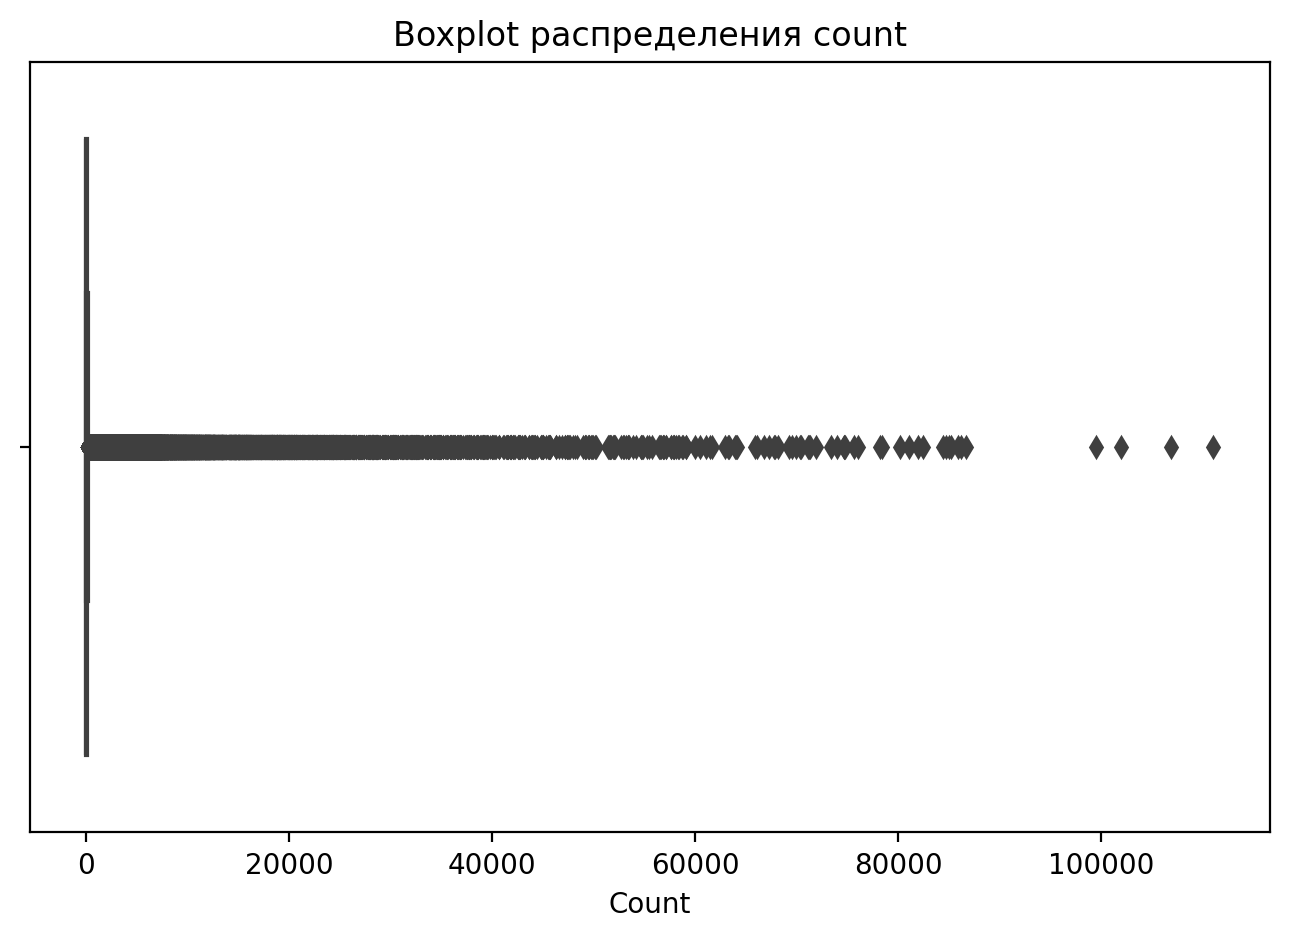

In [ ]:

plt.figure(figsize=(8, 5))
sns.boxplot(x=interactions_track_count['count'])
plt.title('Boxplot распределения count')
plt.xlabel('Count')
plt.show()

Наиболее популярные треки

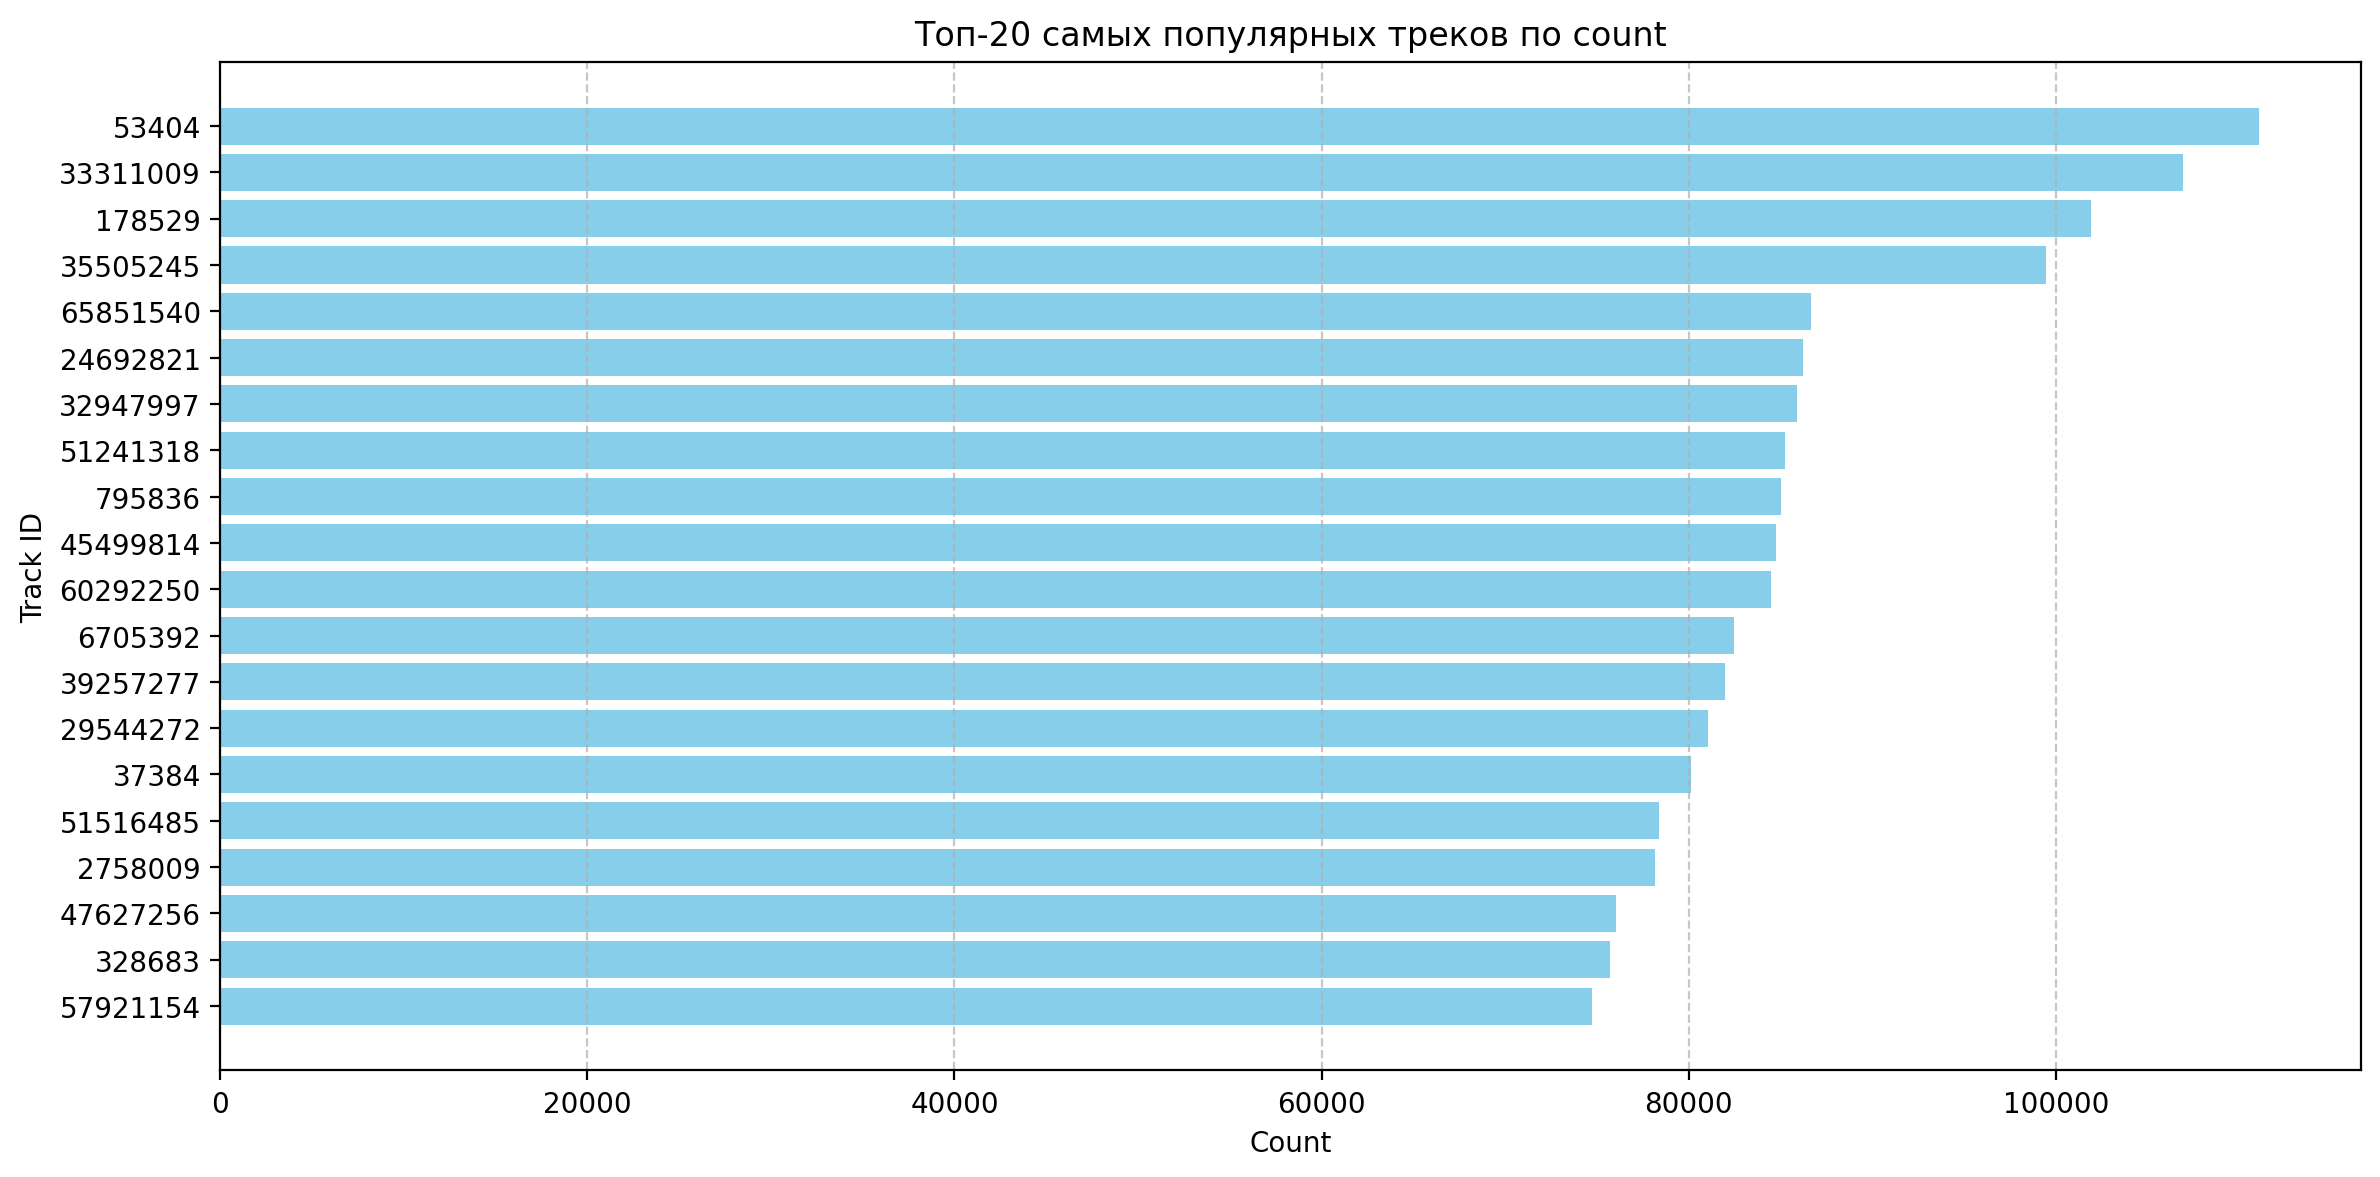

In [25]:
top_n = 20
top_tracks = interactions_track_count.sort_values(by=['count'], ascending=False).head(top_n)
# Строим график
plt.figure(figsize=(12, 6))
plt.barh(top_tracks['track_id'].astype(str), top_tracks['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Track ID')
plt.title(f'Топ-{top_n} самых популярных треков по count')
plt.gca().invert_yaxis()  # Самый популярный сверху
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Наиболее популярные жанры

In [46]:

genre_tracks = tracks[['track_id', 'genres']].explode('genres')
genre_count = genre_tracks.groupby('genres').agg(count=('track_id', 'count'))


genre_counts = genre_count.reset_index().rename(columns={'genres': 'genre_id'})
genre_counts = genre_counts.sort_values('count', ascending=False)

genre_counts

,genre_id,count
10,11,166285
70,75,128212
95,102,118509
63,68,114245
42,47,72311
...,...,...
100,108,14
98,106,4
127,148,4
115,124,2


In [61]:
# catalog_names: id → name
genres_only = catalog_names[catalog_names['type'] == 'genre'][['id', 'name']].rename(columns={'id': 'genre_id'})
genre_counts_named = genre_counts.merge(genres_only, on='genre_id', how='left')

In [60]:
nan_index = genre_counts_named[genre_counts_named['name'].isna()].index
nan_index

Index([ 33,  39,  47,  53,  58,  64,  72,  80,  82,  85,  94, 106, 112, 114,
       119, 126, 129, 130, 139, 141, 148, 151, 152, 153, 162, 164, 167, 170,
       171, 172],
      dtype='int64')

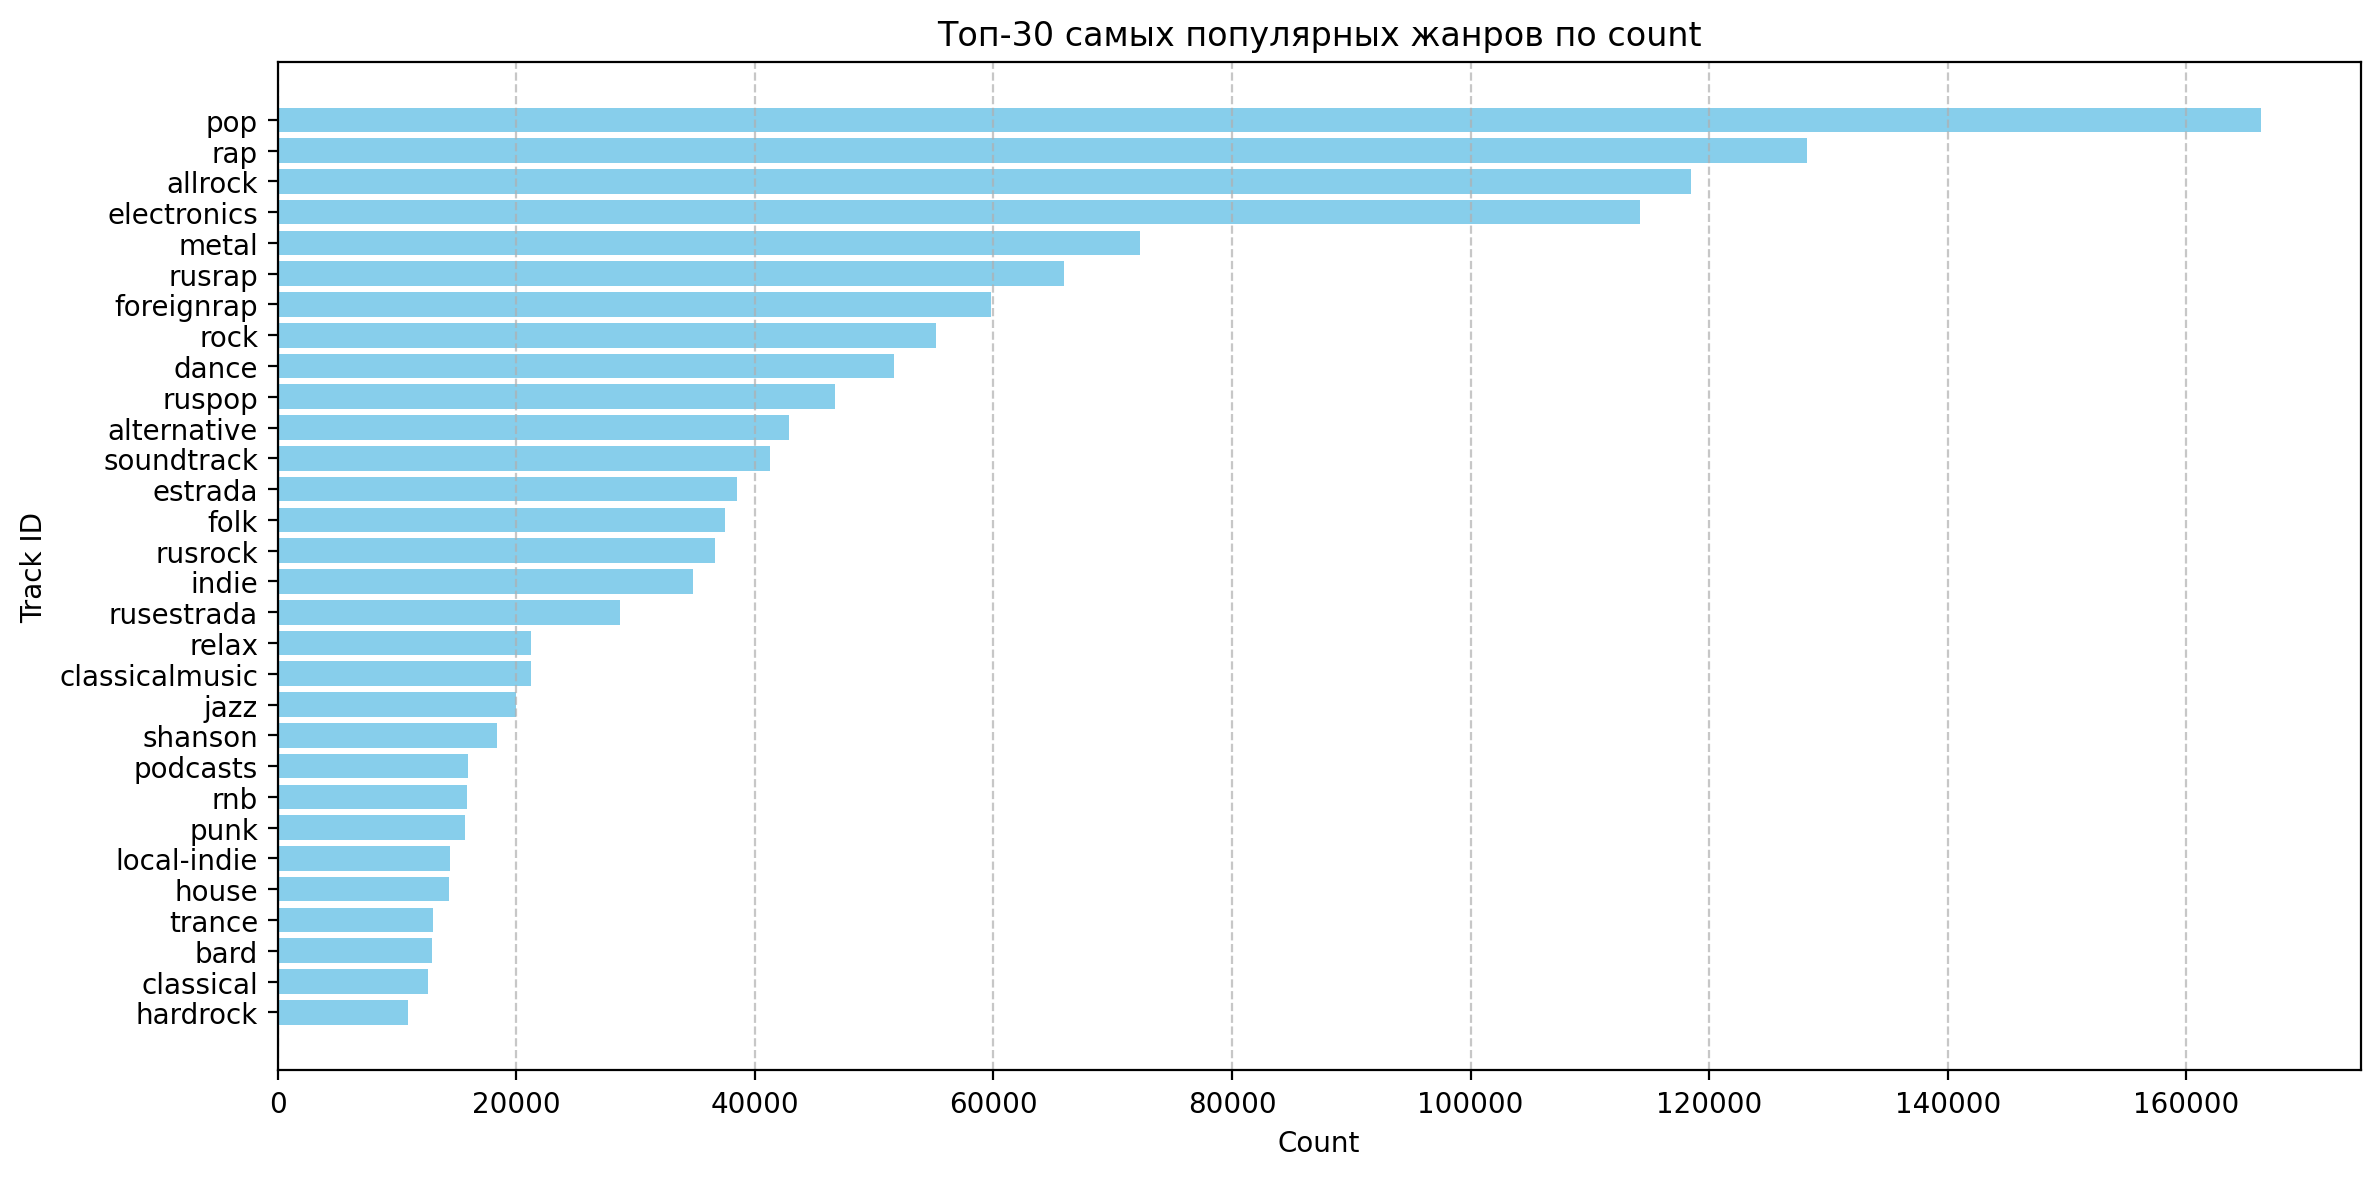

In [58]:
top_n = 30
top_genre = genre_counts_named.sort_values(by=['count'], ascending=False).head(top_n)
# Строим график
plt.figure(figsize=(12, 6))
plt.barh(top_genre['name'].astype(str), top_genre['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Track ID')
plt.title(f'Топ-{top_n} самых популярных жанров по count')
plt.gca().invert_yaxis()  # Самый популярный сверху
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Треки, которые никто не прослушал

In [48]:
# 1. Получаем уникальные прослушанные треки
played_tracks = interactions['track_id'].unique()

# 2. Отбираем треки, которых не было в прослушиваниях
unplayed_tracks = tracks[~tracks['track_id'].isin(played_tracks)]
unplayed_tracks

,track_id,albums,artists,genres


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [ ]:
items = tracks.copy()
events = interactions.copy()

events['user_id'] = pd.factorize(events['user_id'])[0] + 1_000_000
events.rename(columns={'track_id': 'item_id'}, inplace=True)
items.rename(columns={'track_id': 'item_id'}, inplace=True)

In [66]:
del tracks
del interactions

In [65]:
events

,user_id,item_id,track_seq,started_at
0,1000000,99262,1,2022-07-17
1,1000000,589498,2,2022-07-19
2,1000000,590262,3,2022-07-21
3,1000000,590303,4,2022-07-22
4,1000000,590692,5,2022-07-22
...,...,...,...,...
287,2373220,95514767,288,2022-12-29
288,2373220,97220301,289,2022-12-29
289,2373220,97241171,290,2022-12-29
290,2373220,98542641,291,2022-12-29


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [ ]:
items.to_parquet("items.par")
events.to_parquet("events.par")

In [ ]:
s3_path = '/resurse/data/'
local_file_1 = 'items.par'
local_file_2 = 'events.par'

s3.upload_file(local_file_1, S3_BUCKET_NAME, s3_path + local_file_1)
s3.upload_file(local_file_2, S3_BUCKET_NAME, s3_path + local_file_2)

print("Файл успешно отправлен!")

Файл успешно отправлен!


In [37]:
key = 'resurse/data/events.par'

try:
    s3.head_object(Bucket=S3_BUCKET_NAME, Key=key)
    print(f"✅ Файл найден в S3: s3://{S3_BUCKET_NAME}/{key}")
except ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("❌ Файл не найден на S3.")
    else:
        print(f"⚠️ Ошибка при доступе к файлу: {e}")

✅ Файл найден в S3: s3://s3-student-mle-20250424-775513bdf8/resurse/data/events.par


# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [ ]:
del interactions_track_count

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [5]:
items = pd.read_parquet("items.par")
events = pd.read_parquet("events.par")
catalog_names = pd.read_parquet('catalog_names.parquet')


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [6]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int64         
 1   item_id     int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(1), int64(1)
memory usage: 6.2 GB


In [6]:
# зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx].copy()
events_test = events[~train_test_global_time_split_idx].copy()

# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
# количество пользователей, которые есть и в train, и в test
common_users =  set(users_train) & set(users_test)

print(len(users_train), len(users_test), len(common_users))

1342566 783525 752870


In [8]:
# множества пользователей в train и test
set_train = set(users_train)
set_test = set(users_test)

# "холодные" пользователи — в test, но нет в train
cold_users_ids = set_test - set_train

# преобразуем в DataFrame, если нужно
cold_users = pd.DataFrame({'user_id': list(cold_users_ids)})

print(f'Число холодных пользователей: {len(cold_users)}')

Число холодных пользователей: 30655


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [7]:
from sklearn.preprocessing import MinMaxScaler

# считаем популярность айтемов
item_popularity = (
    events_train.groupby("item_id")
    .agg(
        users=("user_id", "nunique"),
        avg_track_seq=("track_seq", "mean")
    )
    .reset_index()
)

# нормализация количества пользователей
scaler = MinMaxScaler()
item_popularity["users_norm"] = scaler.fit_transform(
    item_popularity[["users"]]
)


# сортировка по users_norm и выбор топ-100
top_k_pop_items = item_popularity.sort_values(
    by="users_norm", ascending=False
).head(100)

print(top_k_pop_items.head())


         item_id   users  avg_track_seq  users_norm
9098       53404  110026      17.389681    1.000000
483876  33311009  101076     225.144396    0.918655
26665     178529  100866      38.155781    0.916746
512157  35505245   95523     155.747914    0.868185
368072  24692821   84153     185.660666    0.764844


In [9]:
item_popularity.to_parquet("top_popular.parquet")

In [10]:
import numpy as np

def precision_recall_at_k(recs, ground_truth, k=5):
    precisions, recalls = [], []

    for user, recommended_items in recs.items():
        if user not in ground_truth:
            continue
        true_items = ground_truth[user]
        if not true_items:
            continue

        rec_k = recommended_items[:k]
        hits = len(set(rec_k) & true_items)

        precisions.append(hits / k)
        recalls.append(hits / len(true_items))

    return np.mean(precisions), np.mean(recalls)


def coverage_at_k(recs, all_items, k=5):
    recommended_items = set()
    for rec in recs.values():
        recommended_items.update(rec[:k])
    return len(recommended_items) / len(all_items)


def novelty_at_k(recs, item_popularity, n_users, k=5):
    # вероятность встретить айтем = users / n_users
    item_probs = item_popularity.set_index("item_id")["users"] / n_users

    novelty_scores = []
    for rec in recs.values():
        for item in rec[:k]:
            if item in item_probs:
                novelty_scores.append(-np.log2(item_probs[item]))
    return np.mean(novelty_scores)


In [12]:
get_name_catalog(catalog_names, 53404, 'track')

821569    Smells Like Teen Spirit
Name: name, dtype: object

# Персональные

In [ ]:
events_train["started_at"] = events_train["started_at"].astype("datetime64[s]")
events_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 208731252 entries, 0 to 206
Data columns (total 4 columns):
 #   Column      Dtype        
---  ------      -----        
 0   user_id     int32        
 1   item_id     int32        
 2   track_seq   int16        
 3   started_at  datetime64[s]
dtypes: datetime64[s](1), int16(1), int32(2)
memory usage: 5.1 GB


In [18]:
sample_train = events_train.sample(frac=0.2, random_state=12)
sample_test = events_test.sample(frac=0.2, random_state=12)

Рассчитаем персональные рекомендации.

In [10]:
import scipy
import sklearn.preprocessing

# перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
sample_train["user_id_enc"] = user_encoder.transform(sample_train["user_id"])
sample_test["user_id_enc"] = user_encoder.transform(sample_test["user_id"])

# перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
sample_train["item_id_enc"] = item_encoder.transform(sample_train["item_id"])
sample_test["item_id_enc"] = item_encoder.transform(sample_test["item_id"])
srt = sorted(sample_train['item_id_enc'], reverse=True)
srt[:5]

[999999, 999999, 999999, 999999, 999999]

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(1, 10))
sample_train['track_seq_norm'] = scaler.fit_transform(sample_train[['track_seq']])
sample_test['track_seq_norm'] = scaler.fit_transform(sample_test[['track_seq']])

sample_train.head()

,user_id,item_id,track_seq,started_at,user_id_enc,item_id_enc,track_seq_norm
69,1161927,71725966,70,2022-10-12,161927,874047,1.038932
694,1147203,42237797,695,2022-09-29,147203,607069,1.391574
533,1847394,55608068,534,2022-08-07,847394,739497,1.300733
2483,2046723,63544806,2484,2022-10-07,1046723,808124,2.400978
154,1213324,275785,155,2022-07-15,213324,34439,1.086891


In [14]:
# создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    sample_train["track_seq_norm"],
    (sample_train['user_id_enc'], sample_train['item_id_enc'])),
    dtype=np.float32)

In [15]:
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)

/home/mle-user/mle_projects/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mle-user/mle_projects/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 50/50 [11:46<00:00, 14.13s/it]


In [16]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
         user_id_enc, 
         user_item_matrix[user_id_enc], 
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations

In [17]:
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, N=20)

In [18]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [19]:
als_recommendations = als_recommendations[["user_id", "item_id", "score"]]
als_recommendations.to_parquet("personal_als.parquet")

In [11]:
als_recommendations = pd.read_parquet("personal_als.parquet")


In [17]:

als_recommendations = (
    als_recommendations
    .merge(sample_test[["user_id", "item_id", "track_seq_norm"]]
               .rename(columns={"track_seq_norm": "track_seq_test"}), 
           on=["user_id", "item_id"], how="left")
)

In [18]:
als_recommendations[~als_recommendations['track_seq_test'].isna()]

,user_id,item_id,score,track_seq_test
5317,1000265,62352387,0.008534,1.058026
6804,1000340,50684233,0.001606,1.110629
8706,1000435,62554116,0.010947,1.025488
15543,1000777,76434671,0.004980,1.087852
18960,1000948,54798445,0.001421,1.026030
...,...,...,...,...
27438368,2371918,57921154,0.041723,1.124729
27442138,2372106,10776533,0.003270,1.054230
27449716,2372485,32851197,0.018198,1.274946
27453636,2372681,43052381,0.002299,1.040130


In [10]:
import sklearn.metrics

def compute_ndcg(rating: pd.Series, score: pd.Series, k):

    """ подсчёт ndcg
    rating: истинные оценки
    score: оценки модели
    k: количество айтемов (по убыванию score) для оценки, остальные - отбрасываются
    """
    
    # если кол-во объектов меньше 2, то NDCG - не определена
    if len(rating) < 2:
        return np.nan

    ndcg = sklearn.metrics.ndcg_score(np.asarray([rating.to_numpy()]), np.asarray([score.to_numpy()]), k=k)

    return ndcg

In [49]:
rating_test_idx = ~als_recommendations["track_seq_test"].isnull()
ndcg_at_5_scores = als_recommendations[rating_test_idx].groupby("user_id").apply(lambda x: compute_ndcg(x["track_seq_test"], x["score"], k=5))

In [50]:
print(ndcg_at_5_scores.mean())

0.9988207385910343


# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [19]:
import numpy as np
from implicit.als import AlternatingLeastSquares

# загружаем .npz
data = np.load("als_model.npz")

# создаём новый экземпляр модели
als_model = AlternatingLeastSquares(factors=data['user_factors'].shape[1])
# либо задаём другие параметры, такие как regularization, iterations и т.д.

# восстанавливаем факторы
als_model.user_factors = data['user_factors']
als_model.item_factors = data['item_factors']


/home/mle-user/mle_projects/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mle-user/mle_projects/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


In [20]:
train_item_ids_enc = sample_train['item_id_enc'].unique()
similar_items = als_model.similar_items(train_item_ids_enc, N=11)

# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "item_id_enc": train_item_ids_enc,
    "sim_item_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()
    })
similar_items = similar_items.explode(["sim_item_id_enc", "score"], ignore_index=True)

# приводим типы данных
similar_items["sim_item_id_enc"] = similar_items["sim_item_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")

# получаем изначальные идентификаторы
similar_items["item_id_1"] = item_encoder.inverse_transform(similar_items["item_id_enc"])
similar_items["item_id_2"] = item_encoder.inverse_transform(similar_items["sim_item_id_enc"])

similar_items = similar_items.drop(columns=["item_id_enc", "sim_item_id_enc"])

# убираем пары с одинаковыми объектами
similar_items = similar_items.query("item_id_1 != item_id_2")

In [ ]:
#Сохраниение similar_items в файл
similar_items.to_parquet("similar.parquet")

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [11]:
als_recommendations = pd.read_parquet("personal_als.parquet")


In [13]:
 # задаём точку разбиения
split_date_for_labels = pd.to_datetime("2022-12-29")

split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()

In [13]:
events_labels["target"] = 1

candidates = als_recommendations.merge(events_labels[["user_id", "item_id", "target"]], 
                              on=["user_id", "item_id"], how='left')

candidates["target"] = candidates["target"].fillna(0)

# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

candidates_to_sample.sample(5)

,user_id,item_id,score,target
2866883,1143344,32182642,0.018761,0.0
22213564,2110678,1695498,0.002169,0.0
11506378,1575318,44625560,0.065440,0.0
7017541,1350877,2192826,0.009481,0.0
24935718,2246785,68348389,0.055439,1.0


In [19]:

df_majority = candidates_to_sample[candidates_to_sample['target'] == 0]
df_minority = candidates_to_sample[candidates_to_sample['target'] == 1]

# 2. Определяем, сколько строк класса-большинства оставить (например, в 2 раза больше меньшинства)
n_minority = len(df_minority)
n_to_keep = n_minority * 2 # Или любое другое желаемое число/соотношение

# 3. Случайным образом выбираем нужное количество строк из класса-большинства
# replace=False гарантирует, что строки не будут выбраны повторно
df_majority_undersampled = df_majority.sample(n=n_to_keep, random_state=42, replace=False)

# 4. Объединяем обратно
df_balanced = pd.concat([df_majority_undersampled, df_minority]).sample(frac=1, random_state=42).reset_index(drop=True)

# Проверяем новое распределение
print(df_balanced['target'].value_counts())

target
0.0    233068
1.0    116534
Name: count, dtype: int64


In [14]:
def add_features(df): 
  sample = df.merge(items[["item_id", "albums", "artists", "genres"]],
                              on="item_id", how="left")

  MAX_ALBUMS = 3 
  sample["albums_limited"] = sample["albums"].apply(lambda lst: lst[:MAX_ALBUMS] if isinstance(lst, np.ndarray) else [])
  sample.drop("albums", axis=1, inplace=True)

  sample = sample.explode(["genres"], ignore_index=True)
  sample = sample.explode(["albums_limited"], ignore_index=True)
  sample = sample.explode(["artists"], ignore_index=True)

  # --- Популярность жанра у пользователя ---
  user_genre_popularity = (
      sample.groupby(['user_id', 'genres'])
        .size()
        .reset_index(name='user_genre_popularity')
  )

  # --- Популярность артиста у пользователя ---
  user_artist_popularity = (
      sample.groupby(['user_id', 'artists'])
        .size()
        .reset_index(name='user_artist_popularity')
  )

  # Объединяем обратно с исходным df
  candidates_new_feat = sample.merge(user_genre_popularity, on=['user_id', 'genres'], how='left')
  candidates_new_feat = candidates_new_feat.merge(user_artist_popularity, on=['user_id', 'artists'], how='left')

  return candidates_new_feat


In [16]:
candidates_new_feat = add_features(df_balanced)

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ⚠️</b>

Признаки не до конца сформированы для обучения модели. 
Как правильно построить ранжирующую модель:

Шаг 1:  Создаем целевую переменную - какие треки пользователь прослушал в тестовом периоде. Берем кандидатов для ранжирования - рекомендации от ALS. Добавляем целевую переменную

Шаг 2: Создание признаков (ты начал, но нужно доработать).  Объединяем все признаки. Заполняем пропуски

Шаг 3: Дополнительные признаки которые можно добавить: Популярность жанра у пользователя. Популярность артиста у пользователя. Добавляем эти признаки

Шаг 4: Обучение ранжирующей модели. Выбираем фичи для модели. Разбиваем на train/validation. Обучаем модель. Предсказываем вероятности

Шаг 5: Финальное ранжирование и сохранение. Ранжируем рекомендации для каждого пользователя. Берем топ-10.  Сохраняем итоговые рекомендации

Сравниваем все три подхода.


# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [29]:
from catboost import CatBoostClassifier, Pool

# задаём имена колонок признаков и таргета
features = ['score', 
    'artists', 'genres', 'albums_limited', 'user_genre_popularity', 
    'user_artist_popularity']
target = 'target'

# создаём Pool
train_data = Pool(
    data=candidates_new_feat[features], 
    label=candidates_new_feat[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0,
)

# тренируем модель
cb_model.fit(train_data)

0:	learn: 0.6615843	total: 305ms	remaining: 5m 4s
100:	learn: 0.5067936	total: 28.8s	remaining: 4m 16s
200:	learn: 0.4963705	total: 54.7s	remaining: 3m 37s
300:	learn: 0.4905635	total: 1m 22s	remaining: 3m 12s
400:	learn: 0.4866098	total: 1m 50s	remaining: 2m 45s
500:	learn: 0.4835685	total: 2m 19s	remaining: 2m 18s
600:	learn: 0.4810695	total: 2m 47s	remaining: 1m 50s
700:	learn: 0.4787801	total: 3m 15s	remaining: 1m 23s
800:	learn: 0.4768993	total: 3m 41s	remaining: 54.9s
900:	learn: 0.4750915	total: 4m 9s	remaining: 27.4s
999:	learn: 0.4733776	total: 4m 37s	remaining: 0us


In [30]:
cb_model.save_model("catboost_model.cbm")

# Загрузка модели

In [16]:
from catboost import CatBoostClassifier, Pool
cb_model = CatBoostClassifier()
cb_model.load_model("catboost_model.cbm")

In [17]:
candidates_to_rank = als_recommendations[als_recommendations["user_id"].isin(events_test_2["user_id"].drop_duplicates())]
candidates_to_rank = add_features(candidates_to_rank[:1000000])
candidates_to_rank 

,user_id,item_id,score,artists,genres,albums_limited,user_genre_popularity,user_artist_popularity
0,1000004,694683,0.040634,191175,59,76358,12,24
1,1000004,694683,0.040634,191175,59,2832563,12,24
2,1000004,694683,0.040634,191175,59,2832579,12,24
3,1000004,694683,0.040634,191175,102,76358,31,24
4,1000004,694683,0.040634,191175,102,2832563,31,24
...,...,...,...,...,...,...,...,...
4581706,1206265,32947997,0.064184,381067,11,4172931,33,3
4581707,1206265,44184116,0.063018,6125147,11,5916387,33,2
4581708,1206265,44184116,0.063018,6125147,20,5916387,24,2
4581709,1206265,58515506,0.060960,6229247,11,8888364,33,2


In [18]:
features = ['score', 
    'artists', 'genres', 'albums_limited', 'user_genre_popularity', 
    'user_artist_popularity']
target = 'target'

inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["cb_score"] = predictions[:, 1]
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

max_recommendations_per_user = 100
final_recommendations = candidates_to_rank[candidates_to_rank["rank"] <= max_recommendations_per_user]
final_recommendations.iloc[50]

user_id                    1000004
item_id                   24327639
score                       0.0247
artists                     191175
genres                         102
albums_limited             2832579
user_genre_popularity           31
user_artist_popularity          24
cb_score                  0.130022
rank                            51
Name: 35, dtype: object

In [19]:
final_recommendations

,user_id,item_id,score,artists,genres,albums_limited,user_genre_popularity,user_artist_popularity,cb_score,rank
28,1000004,41625041,0.027300,82972,102,5465764,31,2,0.858062,1
31,1000004,32851197,0.025047,20010,11,15116221,3,6,0.700395,2
27,1000004,41625041,0.027300,82972,14,5465764,19,2,0.693064,3
30,1000004,32851197,0.025047,20010,11,12805317,3,6,0.682212,4
20,1000004,18820599,0.033472,138028,102,5597685,31,9,0.642367,5
...,...,...,...,...,...,...,...,...,...,...
4581666,1206265,18385776,0.076989,2750215,16,1815219,6,9,0.021369,86
4581674,1206265,18385776,0.076989,2750215,68,2042372,6,9,0.021323,87
4581672,1206265,18385776,0.076989,2750215,68,1815219,6,9,0.021055,88
4581680,1206265,18385776,0.076989,2750215,101,2042372,6,9,0.019661,89


In [20]:
final_recommendations = final_recommendations.rename(columns={"score": "als_score"})
final_recommendations.to_parquet("recommendations.parquet")

In [29]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [33]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

In [23]:
events_labels_2 =  events_labels[['user_id', 'item_id', 'track_seq', 'started_at']].copy()

In [19]:
events_labels_2, sample_train

(     user_id   item_id  track_seq started_at
 32   1000003  78194999         33 2022-12-20
 244  1000004  83375862        245 2022-12-18
 245  1000004  83764704        246 2022-12-18
 246  1000004  83858540        247 2022-12-20
 247  1000004  84099295        248 2022-12-21
 ..       ...       ...        ...        ...
 273  2373220  89746495        274 2022-12-28
 274  2373220  90068140        275 2022-12-28
 275  2373220  90954616        276 2022-12-28
 276  2373220  91857574        277 2022-12-28
 277  2373220  92139043        278 2022-12-28
 
 [12596736 rows x 4 columns],
       user_id   item_id  track_seq started_at
 69    1161927  71725966         70 2022-10-12
 694   1147203  42237797        695 2022-09-29
 533   1847394  55608068        534 2022-08-07
 2483  2046723  63544806       2484 2022-10-07
 154   1213324    275785        155 2022-07-15
 ...       ...       ...        ...        ...
 6     1291403      4094          7 2022-01-23
 755   1498059  73111712        756 2022

In [24]:
events_inference = pd.concat([sample_train.reset_index(drop=True), events_labels_2.reset_index(drop=True)])
events_inference = events_inference[events_inference["user_id"].isin(events_test_2["user_id"].drop_duplicates())]


In [26]:
events_test_2

,user_id,item_id,track_seq,started_at
255,1000004,98766295,256,2022-12-29
75,1000005,35931198,76,2022-12-29
46,1000007,96875030,47,2022-12-29
28,1000009,98280795,29,2022-12-29
92,1000011,98597412,93,2022-12-29
...,...,...,...,...
287,2373220,95514767,288,2022-12-29
288,2373220,97220301,289,2022-12-29
289,2373220,97241171,290,2022-12-29
290,2373220,98542641,291,2022-12-29


# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [37]:
def compute_coverage(recs, events_train):
    recommended_items = recs["item_id"].unique()
    all_items = events_train["item_id"].unique()
    coverage = len(recommended_items) / len(all_items)
    return coverage

def compute_novelty(recs, events_train, top_k=None):
    # частота айтемов в train
    item_freq = events_train["item_id"].value_counts(normalize=True)

    # если top_k задан — берём только top_k рекомендаций для каждого пользователя
    if top_k is not None:
        recs = recs.sort_values(["user_id", "score"], ascending=[True, False])
        recs = recs.groupby("user_id").head(top_k)

    # берём уникальные айтемы из рекомендаций
    rec_items = recs["item_id"].unique()

    # вычисляем novelty
    novelty = -np.mean(np.log2(item_freq[rec_items].fillna(1e-10)))
    return novelty

In [12]:
top_recommend = pd.read_parquet("top_popular.parquet")
personal_als = pd.read_parquet("personal_als.parquet")
final_recommendations = pd.read_parquet("recommendations.parquet")

## Финальная рекомнедация

In [39]:
cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    final_recommendations.rename(columns={"cb_score": "score"}), 
    top_k=5)

cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)
cb_coverage_5 = compute_coverage(cb_events_recs_for_binary_metrics_5, events_inference)
cb_novelty_5 = compute_novelty(
    final_recommendations.rename(columns={"cb_score": "score"}), 
    events_inference,
    top_k=5
)

print(f"Итоговая рекомендация:\nprecision: {cb_precision_5:.3f}, recall: {cb_recall_5:.3f}, coverage: {cb_coverage_5:.3f}, novelty: {cb_novelty_5:.3f}")



Common users: 50000
Итоговая рекомендация:
precision: 0.003, recall: 0.005, coverage: 0.076, novelty: 13.928


## Метрика для топа популярных

In [ ]:
top_k_pop_items = top_recommend.sort_values(
    by="users_norm", ascending=False
).head(100)

# топ-100 популярных айтемов
top_k_items = top_k_pop_items["item_id"].tolist()

# рекомендации всем пользователям одинаковые
recs = {u: top_k_items for u in events_test["user_id"].unique()}

# ground truth из test
ground_truth = events_test.groupby("user_id")["item_id"].apply(set).to_dict()

# считаем метрики
precision, recall = precision_recall_at_k(recs, ground_truth, k=5)
coverage = coverage_at_k(recs, events_train["item_id"].unique(), k=5)
novelty = novelty_at_k(recs, item_popularity, events_train["user_id"].nunique(), k=5)

print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")
print(f"Coverage@5: {coverage:.4f}")
print(f"Novelty@5: {novelty:.4f}")


Precision@5: 0.0036
Recall@5: 0.0013
Coverage@5: 0.0000
Novelty@5: 3.7768


## Метрика для персональных

In [41]:
als_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,     # train
    events_test_2,        # test
    personal_als,         # рекомендации
    top_k=5
)
als_precision_5, als_recall_5 = compute_cls_metrics(als_events_recs_for_binary_metrics_5)
als_coverage_5 = compute_coverage(personal_als, events_inference)
als_novelty_5 = compute_novelty(personal_als, events_inference, top_k=5)
print(f"ALS @5:")
print(f"precision: {als_precision_5:.3f}, recall: {als_recall_5:.3f}, "
      f"coverage: {als_coverage_5:.3f}, novelty: {als_novelty_5:.3f}")


Common users: 332864
ALS @5:
precision: 0.001, recall: 0.003, coverage: 0.006, novelty: 13.755


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

              precision    recall  coverage    novelty
CB@5           0.003116  0.005207  0.076175  13.928481
ALS@5          0.000979  0.003005  0.005953  13.755405
TopPopular@5   0.003573  0.001309  0.000005   3.776775


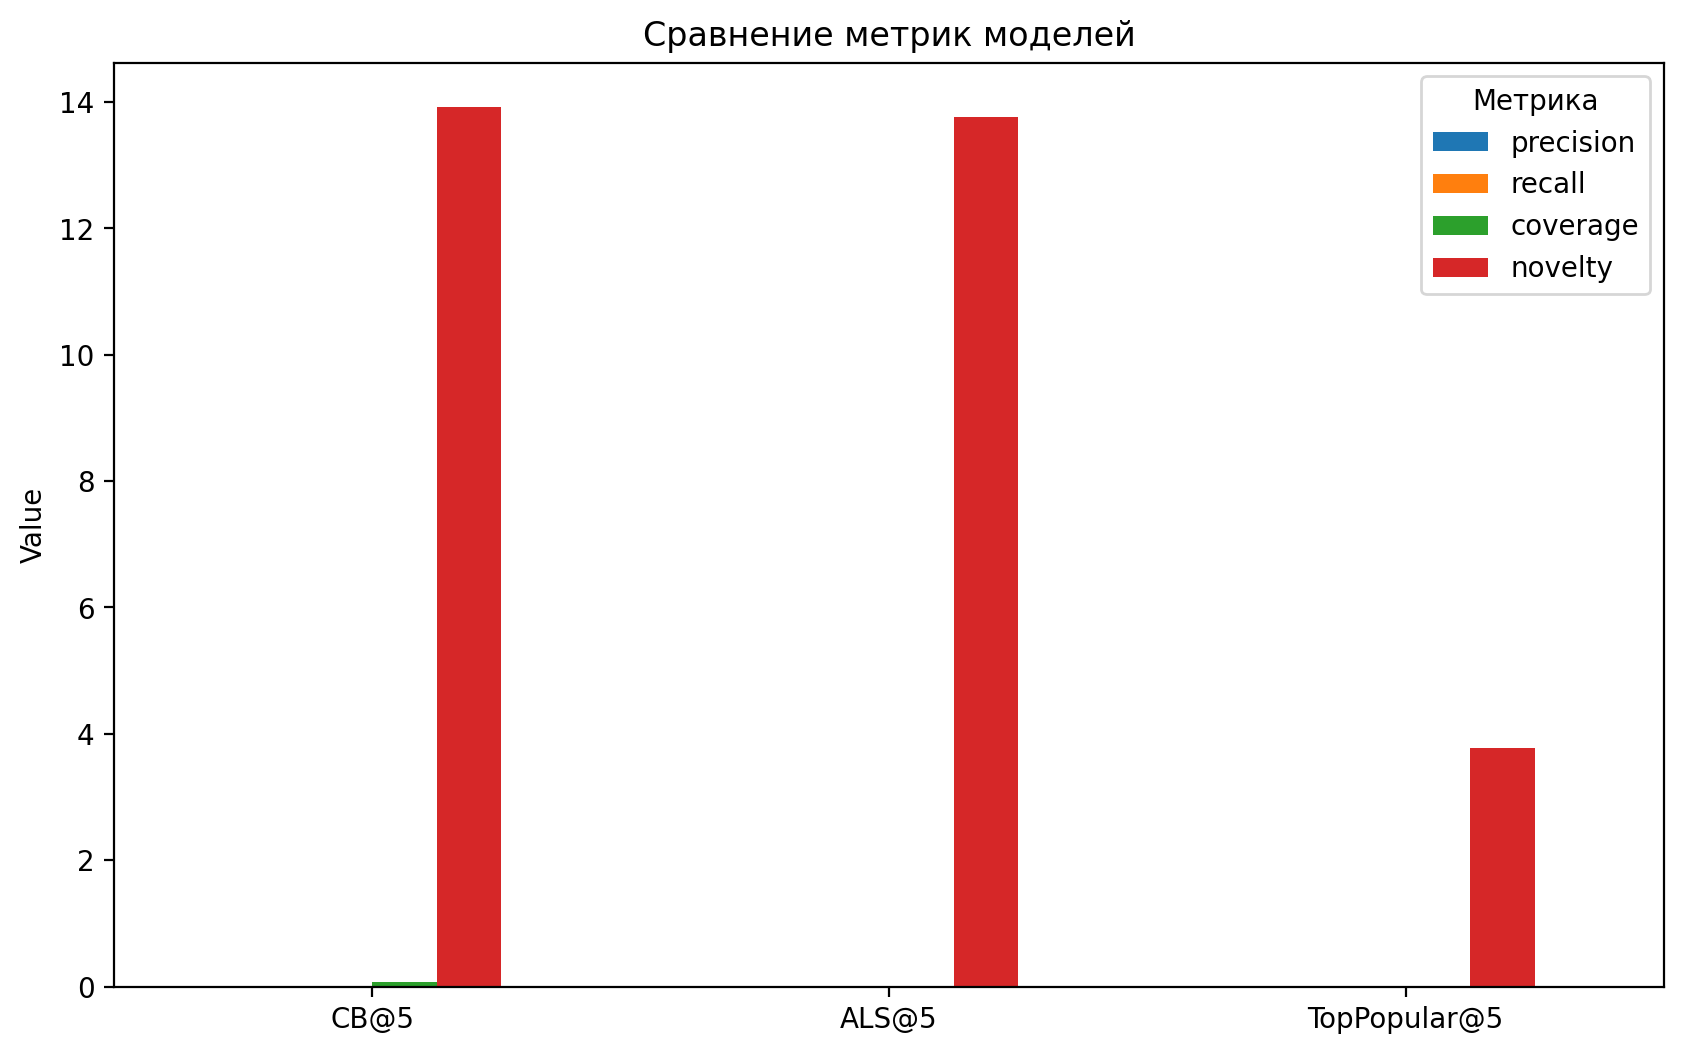

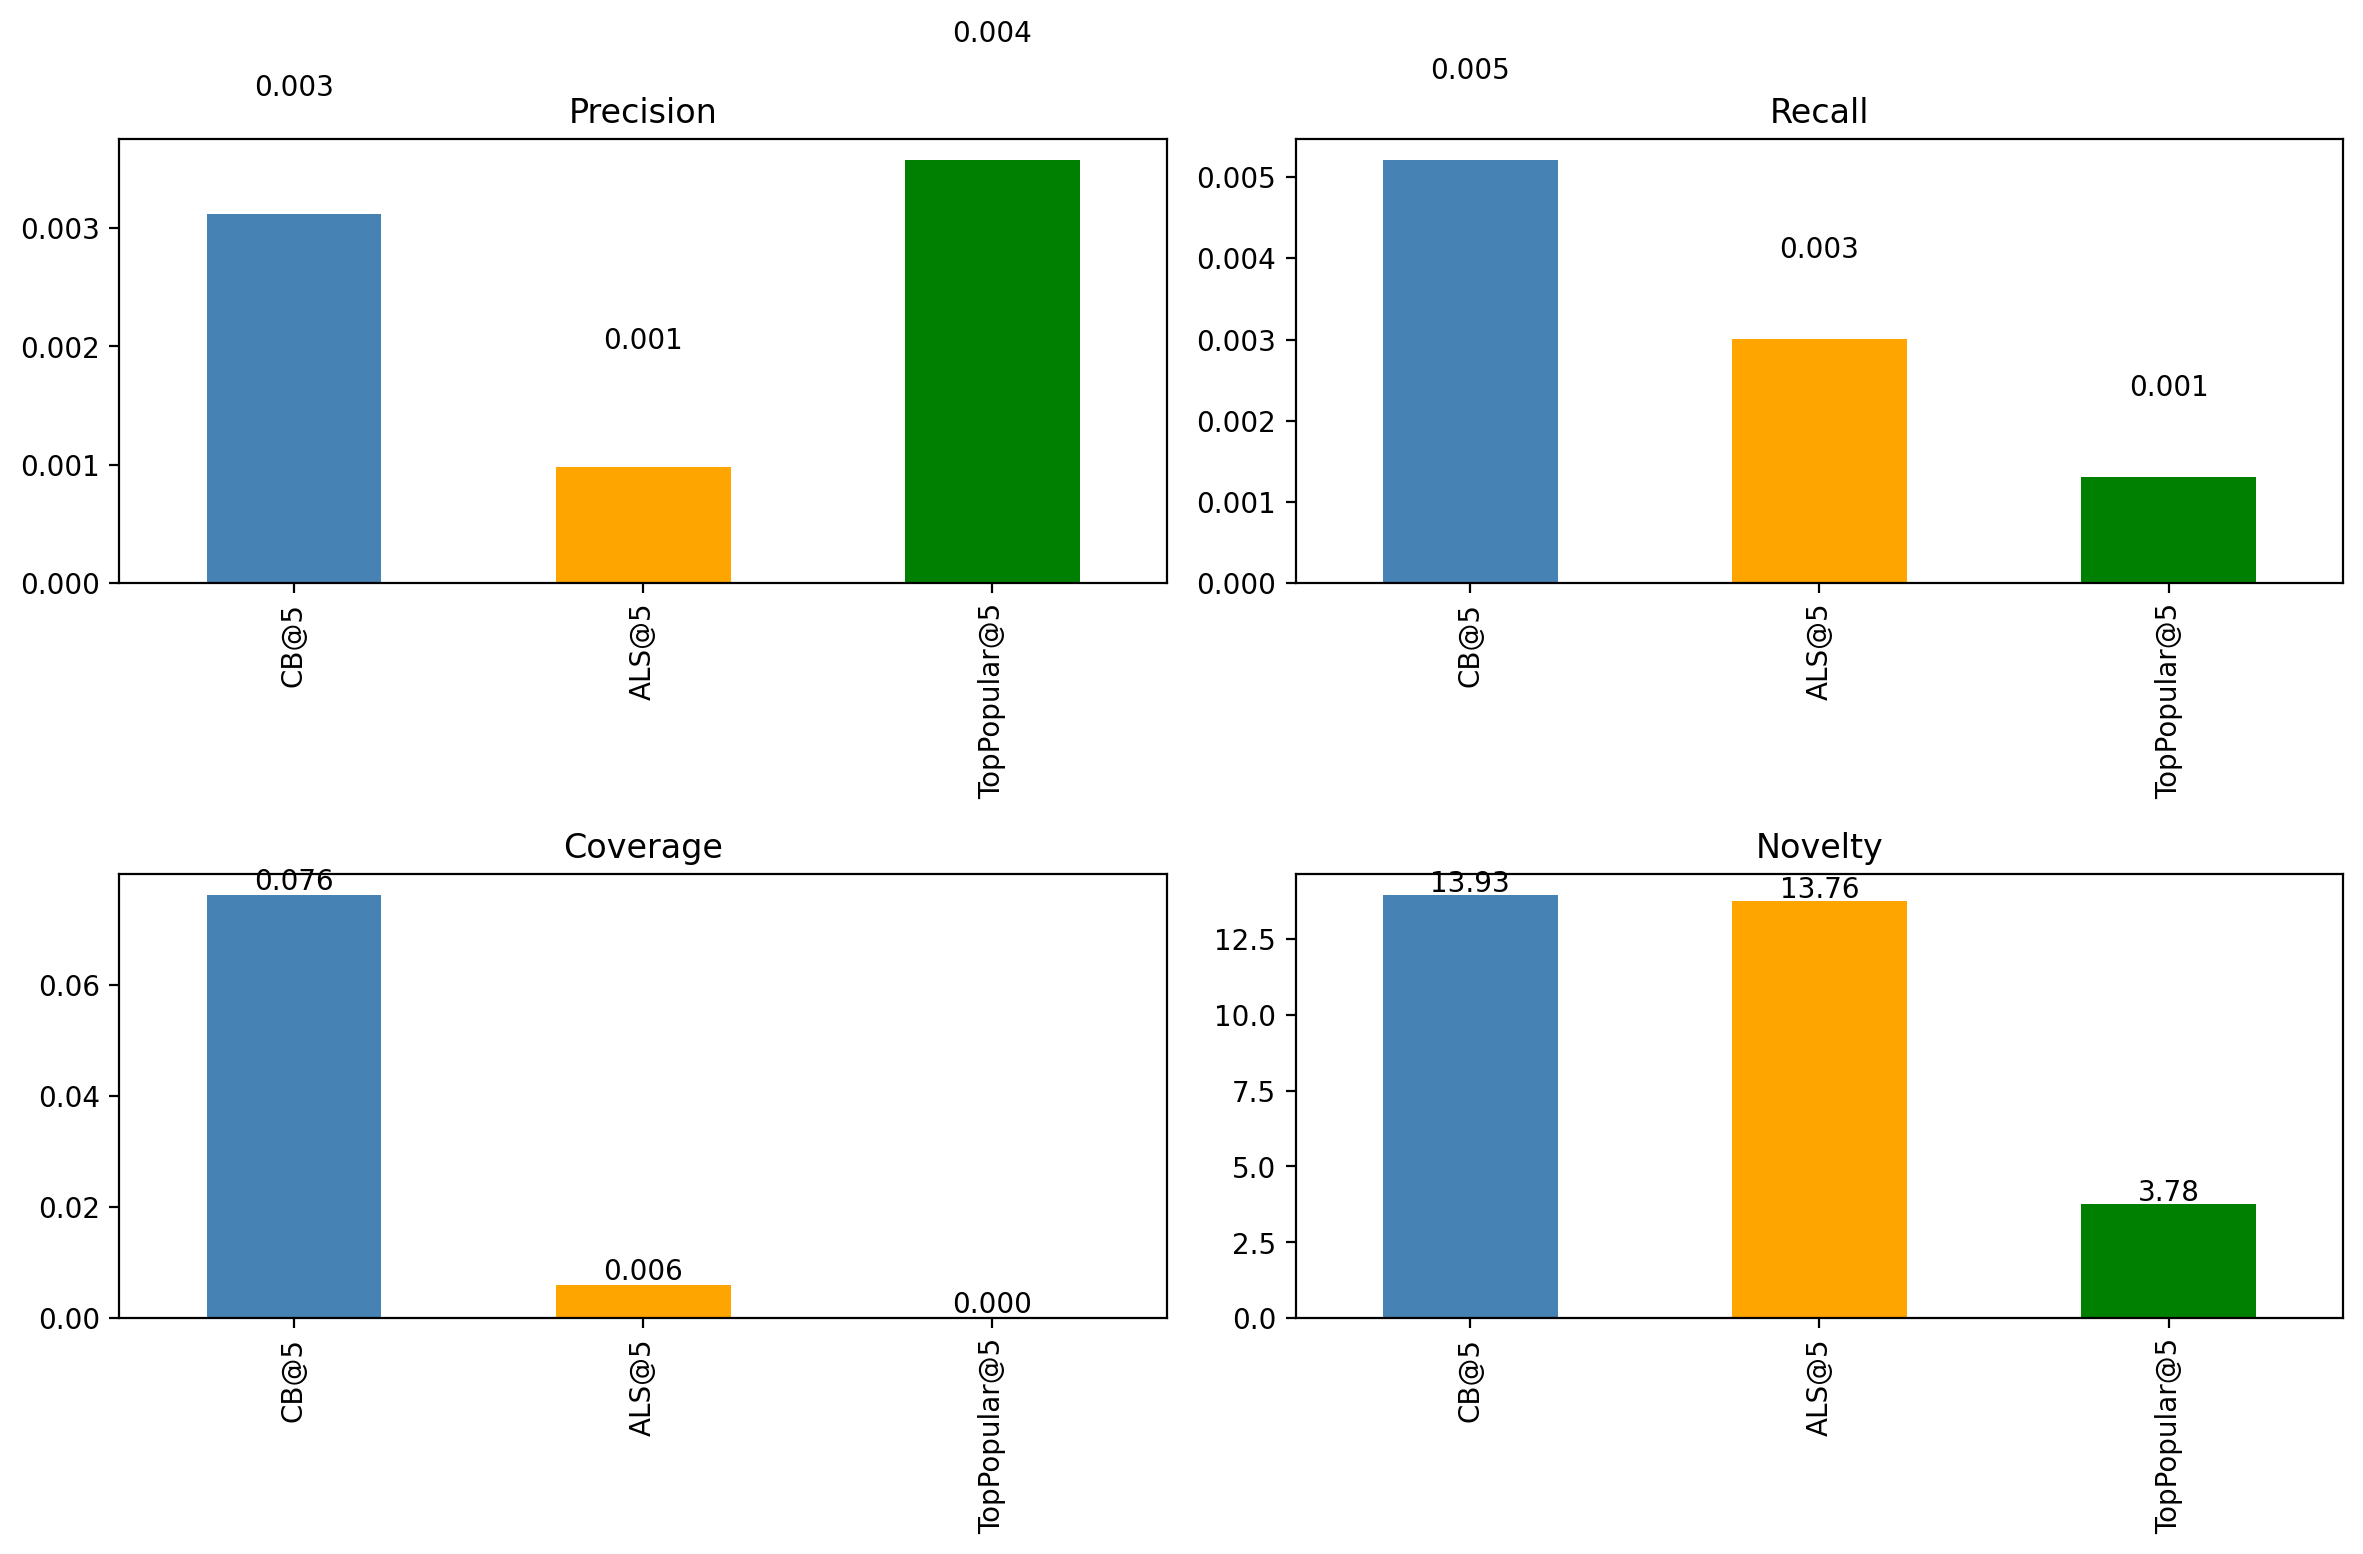

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

cb_metrics = {"precision": cb_precision_5, "recall": cb_recall_5, "coverage": cb_coverage_5, "novelty": cb_novelty_5}
als_metrics = {"precision": als_precision_5, "recall": als_recall_5, "coverage": als_coverage_5, "novelty": als_novelty_5}
top_metrics = {"precision": precision, "recall": recall, "coverage": coverage, "novelty": novelty}  # Top Popular @3

df = pd.DataFrame([cb_metrics, als_metrics, top_metrics], 
                  index=["CB@5", "ALS@5", "TopPopular@5"]).fillna(0)

print(df)

df.plot(kind="bar", figsize=(10,6))
plt.title("Сравнение метрик моделей")
plt.ylabel("Value")
plt.xticks(rotation=0)
plt.legend(title="Метрика")
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    df[col].plot(kind="bar", ax=axes[i], color=['steelblue','orange','green'])
    axes[i].set_title(col.capitalize())
    for j, v in enumerate(df[col]):
        axes[i].text(j, v + (0.001 if col!="novelty" else 0.1), f"{v:.3f}" if col!="novelty" else f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()


In [45]:
s3_path = '/recsys/recommendations/'
local_file_1 = 'top_popular.parquet'
local_file_2 = 'similar.parquet'
local_file_3 = 'recommendations.parquet'
local_file_4 = 'personal_als.parquet'


s3.upload_file(local_file_1, S3_BUCKET_NAME, s3_path + local_file_1)
s3.upload_file(local_file_2, S3_BUCKET_NAME, s3_path + local_file_2)
s3.upload_file(local_file_3, S3_BUCKET_NAME, s3_path + local_file_3)
s3.upload_file(local_file_4, S3_BUCKET_NAME, s3_path + local_file_4)



print("Файл успешно отправлен!")

Файл успешно отправлен!


In [48]:
key = '/recsys/recommendations/recommendations.parquet'

try:
    s3.head_object(Bucket=S3_BUCKET_NAME, Key=key)
    print(f"✅ Файл найден в S3: s3://{S3_BUCKET_NAME}/{key}")
except ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("❌ Файл не найден на S3.")
    else:
        print(f"⚠️ Ошибка при доступе к файлу: {e}")

✅ Файл найден в S3: s3://s3-student-mle-20250424-775513bdf8//recsys/recommendations/recommendations.parquet
